#Football Player Re-Identification in a Video Feed
Detection: Identifying only players in each frame using YOLOv11.

Tracking: Assigning and maintaining unique IDs across frames, handling short occlusions.

Re-ID: Re-identifying players who leave and return using color histograms.

Output: Generating an annotated video and a CSV file with tracking data.

In [ ]:
!pip install opencv-python torch ultralytics numpy scikit-learn tqdm matplotlib pandasFOR

ERROR: Could not find a version that satisfies the requirement pandasFOR (from versions: none)
ERROR: No matching distribution found for pandasFOR


#1. Import packages

In [ ]:
import cv2
import torch
from ultralytics import YOLO
import numpy as np
from tqdm import tqdm
import os

# 2. Load Model

In [ ]:
model = YOLO('../data/yolov11.pt')  # Adjust path as needed

# 3. Read Video

In [ ]:
video_path = '../data/15sec_input_720p.mp4'
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# 4. Output Video Writer

In [ ]:
os.makedirs('../outputs', exist_ok=True)
out = cv2.VideoWriter('../outputs/results.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# 5. Tracking

In [ ]:
next_id = 0
tracks = {}  # id
# for re-identification
track_memory = {}
MEMORY_TTL = int(fps * 3)

In [ ]:
def extract_feature(image, bbox):
    # Extract a simple color histogram as a feature for re-identification
    x1, y1, x2, y2 = map(int, bbox)
    crop = image[max(0, y1):max(0, y2), max(0, x1):max(0, x2)]
    if crop.size == 0:
        return np.zeros(512)
    hist = cv2.calcHist([crop], [0, 1, 2], None, [8,8,8], [0,256,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

In [ ]:
def match_tracks(features, tracks, threshold=0.5):
    # Match detections to existing tracks using cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    matches = []
    unmatched = list(range(len(features)))
    if len(features) == 0 or len(tracks) == 0:
        return matches, unmatched
    for tid, tinfo in tracks.items():
        if tinfo['feature'] is None or len(tinfo['feature']) == 0:
            continue
        sims = cosine_similarity([tinfo['feature']], features)[0]
        best_idx = np.argmax(sims)
        if sims[best_idx] > threshold and best_idx in unmatched:
            matches.append((tid, best_idx))
            unmatched.remove(best_idx)
    return matches, unmatched

In [ ]:
def match_memory(features, memory, threshold=0.5):
    # Try to re-identify lost tracks from memory
    from sklearn.metrics.pairwise import cosine_similarity
    mem_matches = {}
    for idx, feat in enumerate(features):
        best_id, best_sim = None, threshold
        for tid, mem in memory.items():
            sim = cosine_similarity([mem['feature']], [feat])[0][0]
            if sim > best_sim:
                best_sim = sim
                best_id = tid
        if best_id is not None:
            mem_matches[idx] = best_id
    return mem_matches

# 6. Processing Data

In [ ]:
frame_idx = 0
pbar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), desc='Processing video')
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect players (class 0 only)
    results = model(frame)
    detections = []
    for r in results:
        for box in r.boxes:
            if int(box.cls[0]) == 0:  # Only track players
                detections.append(box.xyxy[0].cpu().numpy())

    # Extract features for each detection
    features = [extract_feature(frame, bbox) for bbox in detections]

    # Match to existing tracks
    matches, unmatched = match_tracks(features, tracks)

    # Update matched tracks
    for tid, idx in matches:
        tracks[tid]['bbox'] = detections[idx]
        tracks[tid]['feature'] = features[idx]
        tracks[tid]['last_seen'] = frame_idx

    # Try to re-identify unmatched detections from memory
    mem_matches = match_memory([features[i] for i in unmatched], track_memory, threshold=0.5)
    for rel_idx, mem_id in mem_matches.items():
        idx = unmatched[rel_idx]
        tracks[mem_id] = {
            'bbox': detections[idx],
            'feature': features[idx],
            'last_seen': frame_idx
        }
        if mem_id in track_memory:
            del track_memory[mem_id]
    unmatched = [i for i in unmatched if i not in [unmatched[rel_idx] for rel_idx in mem_matches.keys()]]

    # Assign new IDs to remaining unmatched detections
    for idx in unmatched:
        tracks[next_id] = {
            'bbox': detections[idx],
            'feature': features[idx],
            'last_seen': frame_idx
        }
        next_id += 1

    # Draw results (green boxes for players)
    for tid, tinfo in tracks.items():
        if tinfo['last_seen'] == frame_idx:
            x1, y1, x2, y2 = map(int, tinfo['bbox'])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, f'ID {tid}', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

    out.write(frame)
    frame_idx += 1
    percent_done = (frame_idx / int(cap.get(cv2.CAP_PROP_FRAME_COUNT))) * 100
    print(f"Processing video: {frame_idx}/{int(cap.get(cv2.CAP_PROP_FRAME_COUNT))} ({percent_done:.1f}%) done")
    # pbar.update(1)  # Remove tqdm output

    # Move lost tracks to memory
    lost_ids = [tid for tid, tinfo in tracks.items() if frame_idx - tinfo['last_seen'] > MEMORY_TTL]
    for tid in lost_ids:
        track_memory[tid] = tracks[tid]
        track_memory[tid]['memory_ttl'] = MEMORY_TTL
        del tracks[tid]

    # Decrement memory TTL and remove expired
    expired = [tid for tid, mem in track_memory.items() if 'memory_ttl' in mem and mem['memory_ttl'] <= 0]
    for tid in expired:
        del track_memory[tid]
    for tid in track_memory:
        if 'memory_ttl' in track_memory[tid]:
            track_memory[tid]['memory_ttl'] -= 1

cap.release()
out.release()
pbar.close()
print("Processing complete. Output saved to outputs/results.mp4")

Processing video:   0%|          | 0/375 [00:00<?, ?it/s]


0: 384x640 1 ball, 16 players, 2 referees, 1181.1ms
Speed: 4.0ms preprocess, 1181.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Processing video: 1/375 (0.3%) done

0: 384x640 18 players, 2 referees, 924.9ms
Speed: 3.2ms preprocess, 924.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Processing video: 2/375 (0.5%) done

0: 384x640 1 ball, 16 players, 2 referees, 969.3ms
Speed: 2.9ms preprocess, 969.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Processing video: 3/375 (0.8%) done

0: 384x640 1 ball, 14 players, 2 referees, 918.6ms
Speed: 2.4ms preprocess, 918.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Processing video: 4/375 (1.1%) done

0: 384x640 1 ball, 14 players, 2 referees, 937.8ms
Speed: 2.2ms preprocess, 937.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Processing video: 5/375 (1.3%) done

0: 384x640 1 ball, 16 players, 2 referees, 954.8ms
Speed: 2.2ms preprocess,

Processing video:   0%|          | 0/375 [09:02<?, ?it/s]

Processing video: 375/375 (100.0%) done
Processing complete. Output saved to outputs/results.mp4


# 7. Save results

In [ ]:
# 7. Save tracking results to CSV
import pandas as pd
results_list = []
for tid, tinfo in {**tracks, **track_memory}.items():
    x1, y1, x2, y2 = map(int, tinfo['bbox'])
    results_list.append({
        'id': tid,
        'frame': tinfo['last_seen'],
        'x1': x1,
        'y1': y1,
        'x2': x2,
        'y2': y2
    })
df = pd.DataFrame(results_list)
df.to_csv('../outputs/results.csv', index=False)
print("Tracking results saved to outputs/results.csv")

Tracking results saved to outputs/results.csv


# 8. Validation (displaying few frames)

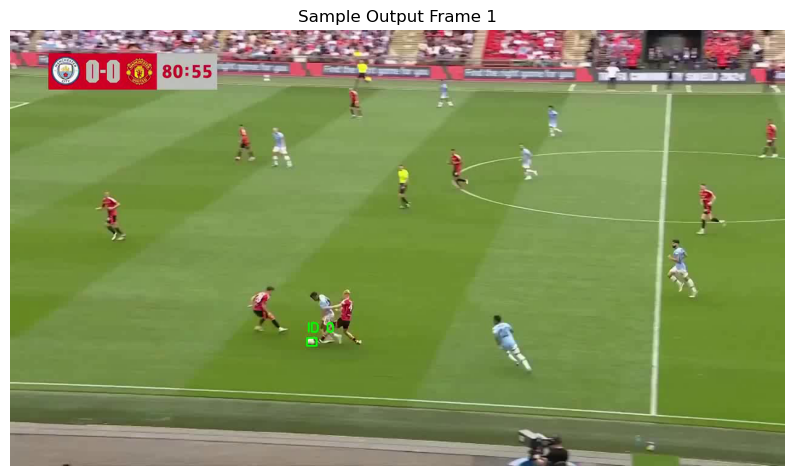

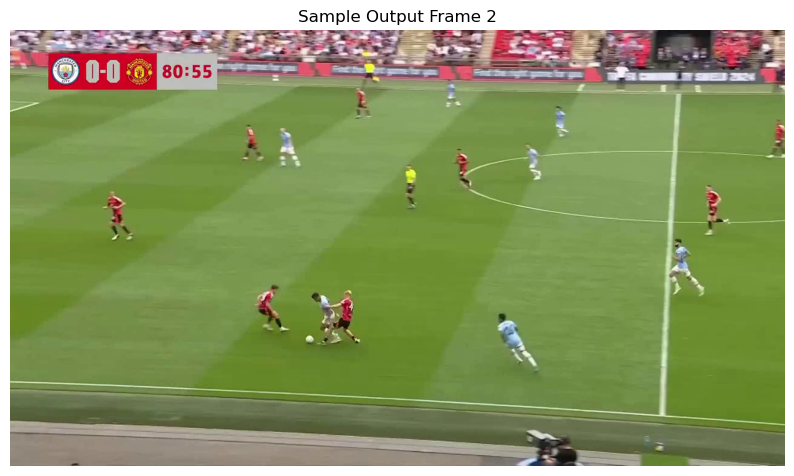

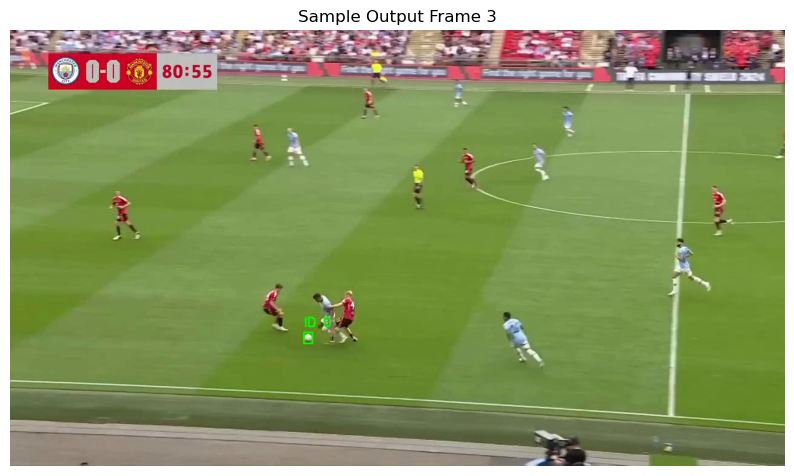

In [ ]:
import matplotlib.pyplot as plt
sample_cap = cv2.VideoCapture('../outputs/results.mp4')
for i in range(3):
    ret, frame = sample_cap.read()
    if not ret:
        break
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Sample Output Frame {i+1}")
    plt.axis('off')
    plt.show()
sample_cap.release()